In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from matplotlib.lines import Line2D
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7) #set figsize for all
sns.set(palette = 'RdBu')
sns.set_style('white')

### Read data and concat

Two sources:
* 1969-1988: Center for Disease Control from Jake Vpd
* 1994-2014: Two sets from FiveThirtyEight
  - Center for Disease Control (1994-2003)
  - Social Security (2004-2014)

In [2]:
# First set
vpd = pd.read_csv('https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv').groupby(['year', 'month', 'day'])['births'].sum().reset_index()
vpd['day'] = vpd['day'].astype(int)
# need to remove a few invalid dates with sigma clipping from Jake VPD's code
quartiles = np.percentile(vpd['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.7413 * (quartiles[2] - quartiles[0])
vpd = vpd.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

# Second set
fte_cdc = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/births/US_births_1994-2003_CDC_NCHS.csv')
fte_ss = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/births/US_births_2000-2014_SSA.csv')
fte = pd.concat([fte_cdc, fte_ss[fte_ss['year'] > 2003]], axis=0) #concat two 538 sets
fte = fte.drop(columns=['day_of_week']).rename(columns = {'date_of_month':'day'}) #rename to get same column names

# Concat
birth_df = pd.concat([vpd, fte], axis=0)

In [3]:
birth_df.head()

,year,month,day,births
0,1969,1,1,8486
1,1969,1,2,9002
2,1969,1,3,9542
3,1969,1,4,8960
4,1969,1,5,8390


### Plot birthdays

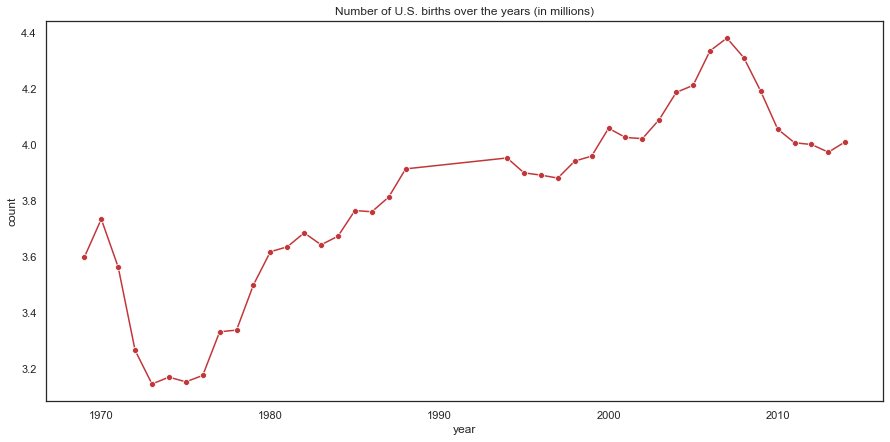

In [4]:
#Plot
data = birth_df.groupby('year')['births'].sum().reset_index(name='count')

ax = sns.lineplot(x=data['year'], y=data['count']/np.power(10, 6), marker='o')
ax.set_title('Number of U.S. births over the years (in millions)')
plt.show()

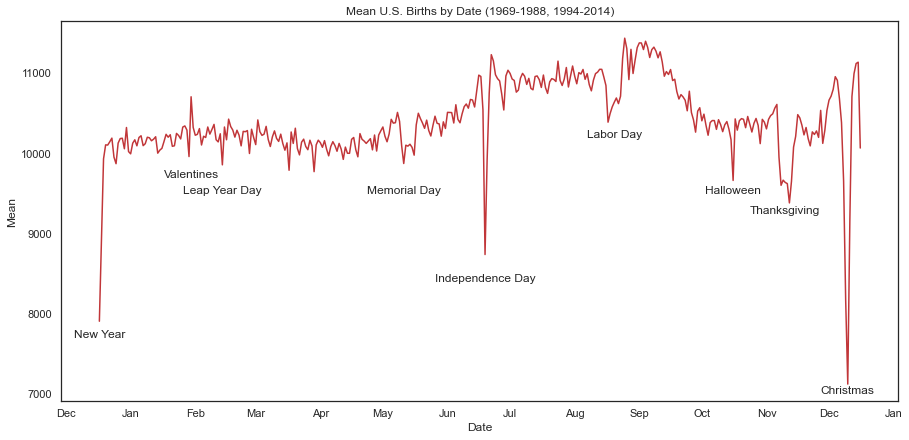

In [5]:
# Get date (pick leap year as placeholder)
birth_df['date'] = pd.to_datetime('2012-'+birth_df['month'].astype(str)+'-'+birth_df['day'].astype(str))
data = birth_df.groupby('date')['births'].mean().reset_index(name='mean').sort_values('date')

# Plot
ax = sns.lineplot(x=data['date'], y=data['mean'])
ax.set(title='Mean U.S. Births by Date (1969-1988, 1994-2014)', ylabel='Mean', xlabel='Date')

# day labels
ax.text(datetime.datetime(2012, 1, 1), 7700, "New Year", ha='center')
ax.text(datetime.datetime(2012, 2, 14), 9700, "Valentines", ha='center')
ax.text(datetime.datetime(2012, 2, 29), 9500, "Leap Year Day", ha='center')
ax.text(datetime.datetime(2012, 5, 26), 9500, "Memorial Day", ha='center')
ax.text(datetime.datetime(2012, 7, 4), 8400, "Independence Day", ha='center')
ax.text(datetime.datetime(2012, 9, 4), 10200, "Labor Day", ha='center')
ax.text(datetime.datetime(2012, 10, 31), 9500, "Halloween", ha='center')
ax.text(datetime.datetime(2012, 11, 25), 9250, "Thanksgiving", ha='center')
ax.text(datetime.datetime(2012, 12, 25), 7000, "Christmas", ha='center')

# adjust x-axis
ax.xaxis.set_major_locator(mpl.dates.MonthLocator()) #force major ticks on a monthly time scale
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%b'))

In [6]:
data['date'] = data['date'].dt.strftime('%B %d')

print("Top birthdays sorted by mean: ")
# (data.sort_values('mean', ascending=False)
#     .style
#     .format({'mean': '{:20,.0f}'})
#     .hide_index()
#     .background_gradient(cmap='RdBu'))

Top birthdays sorted by mean: 


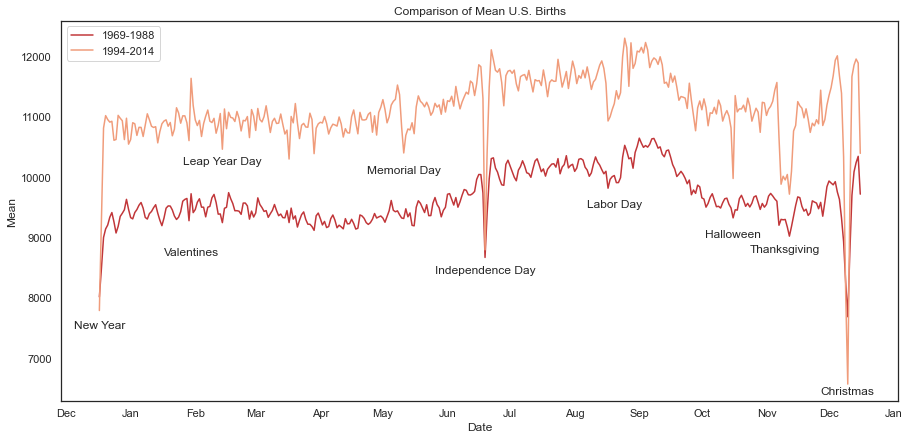

In [7]:
# Has trend changed? Compared the two periods
fig, ax = plt.subplots()

for i, df in enumerate([vpd, fte]):
    df['date'] = pd.to_datetime('2012-'+df['month'].astype(str)+'-'+df['day'].astype(str))
    data = df.groupby('date')['births'].mean().reset_index(name='mean').sort_values('date')
     
    sns.lineplot(x=data['date'], y=data['mean'], ax=ax)    
    
ax.text(datetime.datetime(2012, 1, 1), 7500, "New Year", ha='center')
ax.text(datetime.datetime(2012, 2, 14), 8700, "Valentines", ha='center')
ax.text(datetime.datetime(2012, 2, 29), 10200, "Leap Year Day", ha='center')
ax.text(datetime.datetime(2012, 5, 26), 10050, "Memorial Day", ha='center')
ax.text(datetime.datetime(2012, 7, 4), 8400, "Independence Day", ha='center')
ax.text(datetime.datetime(2012, 9, 4), 9500, "Labor Day", ha='center')
ax.text(datetime.datetime(2012, 10, 31), 9000, "Halloween", ha='center')
ax.text(datetime.datetime(2012, 11, 25), 8750, "Thanksgiving", ha='center')
ax.text(datetime.datetime(2012, 12, 25), 6400, "Christmas", ha='center')

ax.xaxis.set_major_locator(mpl.dates.MonthLocator()) #force major ticks on a monthly time scale
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%b'))

ax.set(title='Comparison of Mean U.S. Births', ylabel='Mean', xlabel='Date')
ax.legend(['1969-1988','1994-2014'])
plt.show()

Some biggest differences in the 21st Century:
- More babies are born
- More births on Valentine's
- BIG drops on major holidays: New Year, Memorial, 4th July, Labor, Halloween, Thanksviging, and Christmas -- Americans take holidays more seriously?

### Understand conception periods

#### By pure dates

In [8]:
# Get conceived dates
birth_df['date'] = [datetime.datetime(year, month, day) for (year, month, day) in zip(birth_df['year'], birth_df['month'], birth_df['day'])]
birth_df['conceived_date'] = birth_df['date'] - datetime.timedelta(days=280) #39 weeks
birth_df['dayofweek'] = birth_df['conceived_date'].dt.strftime('%A')

# Group by
birth_df['conceived_date'] = birth_df['conceived_date'].dt.strftime('%b %d')
data = birth_df[['conceived_date', 'dayofweek', 'births']]
data.head()

,conceived_date,dayofweek,births
0,Mar 27,Wednesday,8486
1,Mar 28,Thursday,9002
2,Mar 29,Friday,9542
3,Mar 30,Saturday,8960
4,Mar 31,Sunday,8390


In [9]:
# Get dummies
for col in ['dayofweek', 'conceived_date']:
    dummy = pd.get_dummies(data[col])
    data = pd.concat([data, dummy], axis=1)

data = data.drop(columns=['conceived_date', 'dayofweek', 'Jan 17', 'Monday']) #drop Jan 17(average), Monday as they are our base
data.head()

,births,Friday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Apr 01,Apr 02,Apr 03,...,Sep 21,Sep 22,Sep 23,Sep 24,Sep 25,Sep 26,Sep 27,Sep 28,Sep 29,Sep 30
0,8486,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9002,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9542,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8960,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8390,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Number of Birth Conceptions = $\alpha_{364}$*Dates + $\beta_6$*Day of week + $error$

In [10]:
Y = data['births']
X = data[data.columns[1:]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 births   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     55.50
Date:                Sun, 10 May 2020   Prob (F-statistic):               0.00
Time:                        13:07:21   Log-Likelihood:            -1.2767e+05
No. Observations:               14975   AIC:                         2.561e+05
Df Residuals:                   14603   BIC:                         2.589e+05
Df Model:                         371                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.076e+04    194.415     55.362      0.000    1.04e+04    1.11e+04
Friday       481.3151     37.844     12.718      0.000     407.136     555.495
Saturday   -2120.0079     37.816    -56.060      0.000   -2194.133   -2045.883
Sunday     -2831.5389     37.858    -74.794      0.000   -2905.745   -2757.333
Thursday     514.9089     37.843     13.606      0.000     440.731     589.086
Tuesday      836.1911     37.857     22.088      0.000     761.986     910.396
Wednesday    592.9254     37.817     15.679      0.000     518.799     667.051
Apr 01      -309.4013    272.852     -1.134      0.257    -844.225     225.423
Apr 02      -340.1576    272.852     -1.247      0.213    -874.982     194.666
Apr 03      -460.6027    272.849     -1.688      0.091    -995.421      74.215
Apr 04      -498.8824    272.853     -1.828      0.068   -1033.710      35.945
Apr 05      -250.4390    272.842     -0.918      0.359    -785.245     284.367
Apr 06      -135.2537    272.853     -0.496      0.620    -670.081     399.573
Apr 07      -176.9292    272.849     -0.648      0.517    -711.747     357.889
Apr 08      -396.9135    272.852     -1.455      0.146    -931.738     137.911
Apr 09      -207.5723    272.852     -0.761      0.447    -742.396     327.252
Apr 10      -391.8710    272.849     -1.436      0.151    -926.689     142.947
Apr 11      -375.5409    272.853     -1.376      0.169    -910.368     159.286
Apr 12      -251.3902    272.842     -0.921      0.357    -786.196     283.415
Apr 13      -151.0586    272.853     -0.554      0.580    -685.886     383.769
Apr 14      -271.5145    272.849     -0.995      0.320    -806.332     263.303
Apr 15      -256.3281    272.852     -0.939      0.348    -791.152     278.496
Apr 16      -310.5479    272.852     -1.138      0.255    -845.372     224.276
Apr 17      -318.0173    272.849     -1.166      0.244    -852.835     216.801
Apr 18      -249.4434    272.853     -0.914      0.361    -784.271     285.384
Apr 19      -177.1951    272.842     -0.649      0.516    -712.001     357.611
Apr 20      -125.6440    272.853     -0.460      0.645    -660.471     409.183
Apr 21      -208.6365    272.849     -0.765      0.444    -743.454     326.181
Apr 22      -277.5232    272.852     -1.017      0.309    -812.347     257.301
Apr 23      -322.9137    272.852     -1.183      0.237    -857.738     211.910
Apr 24      -411.5783    272.849     -1.508      0.131    -946.396     123.240
Apr 25      -329.6629    272.853     -1.208      0.227    -864.490     205.164
Apr 26      -315.8049    272.842     -1.157      0.247    -850.611     219.001
Apr 27      -172.5464    272.853     -0.632      0.527    -707.374     362.281
Apr 28      -128.0511    272.849     -0.469      0.639    -662.869     406.767
Apr 29      -252.8159    272.852     -0.927      0.354    -787.640     282.008
Ap

$R^2$ is .585, so dates and week days have reasonable explanatory power for conception.

In [11]:
# Print top 15 dates
results_df = pd.DataFrame({'date':results.params.index, 'coefficient':results.params.values,
                          'lower': results.conf_int()[0], 'upper':results.conf_int()[1]})
results_df = results_df[~(results_df['date'].isin(['const', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']))]
results_df.sort_values(by='coefficient', ascending=False)[:15]

,date,coefficient,lower,upper
Dec 14,Dec 14,996.356018,461.528887,1531.183150
Dec 13,Dec 13,976.658537,441.852869,1511.464204
Dec 03,Dec 03,945.135033,410.310987,1479.959079
Dec 15,Dec 15,932.851325,398.033425,1467.669226
Dec 12,Dec 12,922.093211,387.266081,1456.920341
Dec 10,Dec 10,898.525277,363.701231,1433.349323
Dec 09,Dec 09,887.306028,352.481980,1422.130075
Dec 11,Dec 11,868.982676,334.164773,1403.800578
Dec 16,Dec 16,865.769443,330.945395,1400.593490
Dec 20,Dec 20,858.365854,323.560186,1393.171522


/Users/taidnguyen/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


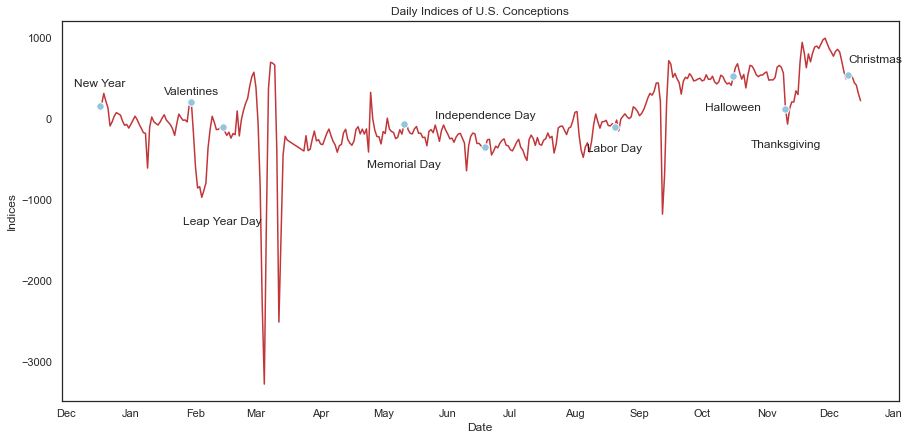

In [12]:
data = results_df[7:]
data['date'] = pd.to_datetime('2012 ' + data['date'], format='%Y %b %d', errors='ignore') #get date (pick leap year as placeholder)


# Plot
ax = sns.lineplot(x=data['date'], y=data['coefficient'])
ax.set(title='Daily Indices of U.S. Conceptions', ylabel='Indices', xlabel='Date')

# day labels
ax.text(datetime.datetime(2012, 1, 1), 400, "New Year", ha='center')
ax.text(datetime.datetime(2012, 2, 14), 300, "Valentines", ha='center')
ax.text(datetime.datetime(2012, 2, 29), -1300, "Leap Year Day", ha='center')
ax.text(datetime.datetime(2012, 5, 26), -600, "Memorial Day", ha='center')
ax.text(datetime.datetime(2012, 7, 4), 0, "Independence Day", ha='center')
ax.text(datetime.datetime(2012, 9, 4), -400, "Labor Day", ha='center')
ax.text(datetime.datetime(2012, 10, 31), 100, "Halloween", ha='center')
ax.text(datetime.datetime(2012, 11, 25), -350, "Thanksgiving", ha='center')
ax.text(datetime.datetime(2012, 12, 25), 700, "Christmas", ha='left')
#dots
point_dict = data.set_index('date').to_dict('index')

def add_dot(year, month, day, value):
    ax.plot(datetime.datetime(year, month, day), point_dict[datetime.datetime(year, month, day)][value], 
            marker='.', markersize=15, markeredgecolor='white', color='#92c5de')

add_dot(2012, 1, 1, value='coefficient')
add_dot(2012, 2, 14, value='coefficient')
add_dot(2012, 2, 29, value='coefficient')
add_dot(2012, 5, 26, value='coefficient')
add_dot(2012, 7, 4, value='coefficient')
add_dot(2012, 9, 4, value='coefficient')
add_dot(2012, 10, 31, value='coefficient')
add_dot(2012, 11, 25, value='coefficient')
add_dot(2012, 12, 25, value='coefficient')

# adjust x-axis
ax.xaxis.set_major_locator(mpl.dates.MonthLocator()) #force major ticks on a monthly time scale
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%b'))

/Users/taidnguyen/.pyenv/versions/miniconda3-4.7.12/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


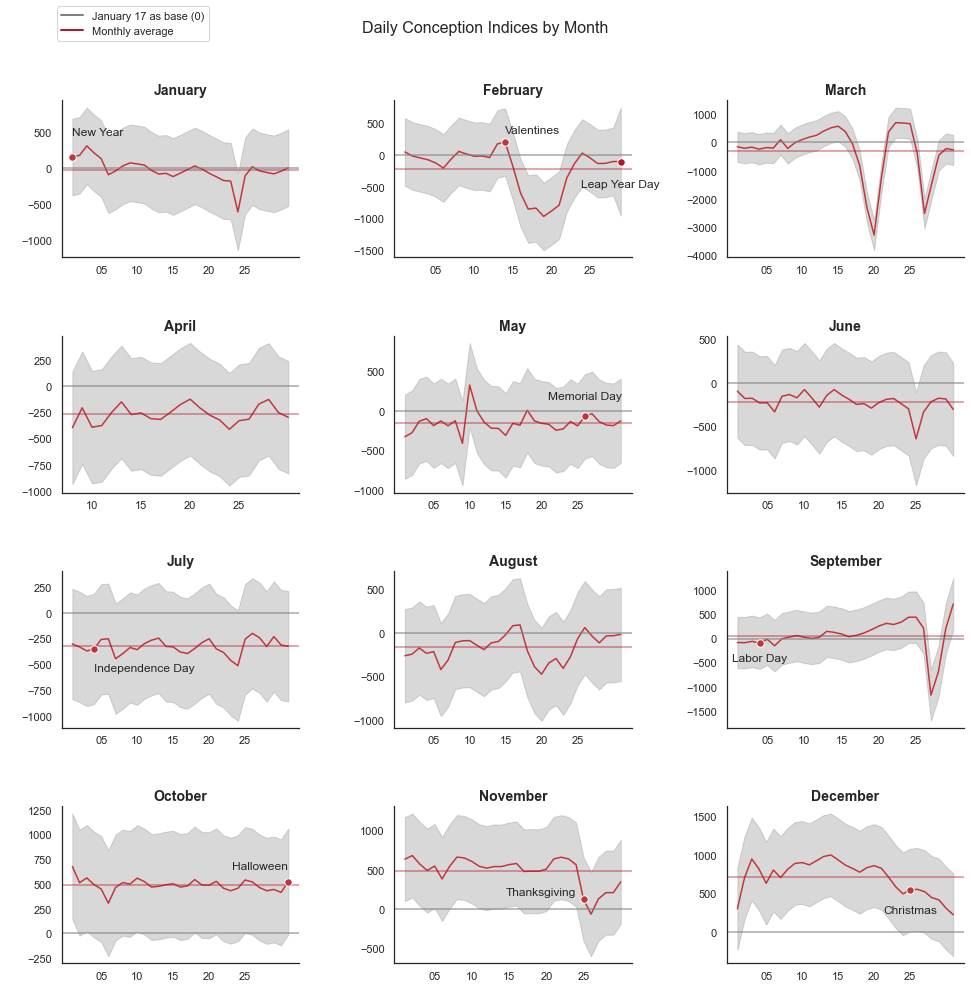

In [13]:
# FacetGrid
data['month'] = data['date'].dt.strftime('%B') 

# Init
g = sns.FacetGrid(data.sort_values(['date']), col='month', col_wrap=3, sharey=False, sharex=False, 
                  height=3.5, aspect=1.3)

# Map lines
def lines(x,y, **kwargs):
    ax = sns.lineplot(x,y,**kwargs)
    ax.axhline(0, alpha=0.7, color='gray')
    ax.axhline(np.mean(y), alpha=0.5, color='#b2182b')
    ax.xaxis.set_major_locator(mpl.dates.MonthLocator()) #force major ticks on a monthly time scale
    ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=[0,1,5,10,15,20,25]))
    ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%d'))
    
g = g.map(lines, 'date', 'coefficient')
g = g.map(plt.fill_between, 'date', 'lower', 'upper', color='gray', alpha=0.3)
g = g.set_titles(col_template="{col_name}", size=14, fontweight='bold')
g = g.set_xlabels(' ')
g = g.set_ylabels(' ')
g = g.set_xticklabels(' ')
 
# Manually add major dates
point_dict = data.set_index('date').to_dict('index') 

g.axes[0].text(datetime.datetime(2012, 1, 1), 470, "New Year", ha='left', fontsize=12)
g.axes[0].plot(datetime.datetime(2012, 1, 1), point_dict[datetime.datetime(2012, 1, 1)]['coefficient'], marker='.', markersize=15, markeredgecolor='white')
g.axes[1].text(datetime.datetime(2012, 2, 14), 350, "Valentines", ha='left', fontsize=12)
g.axes[1].plot(datetime.datetime(2012, 2, 14), point_dict[datetime.datetime(2012, 2, 14)]['coefficient'], marker='.', markersize=15, markeredgecolor='white')
g.axes[1].text(datetime.datetime(2012, 2, 29), -500, "Leap Year Day", ha='center', fontsize=12)
g.axes[1].plot(datetime.datetime(2012, 2, 29), point_dict[datetime.datetime(2012, 2, 29)]['coefficient'], marker='.', markersize=15, markeredgecolor='white', color='#b2182b')
g.axes[4].text(datetime.datetime(2012, 5, 26), 150, "Memorial Day", ha='center', fontsize=12)
g.axes[4].plot(datetime.datetime(2012, 5, 26), point_dict[datetime.datetime(2012, 5, 26)]['coefficient'], marker='.', markersize=15, markeredgecolor='white')
g.axes[6].text(datetime.datetime(2012, 7, 4), -570, "Independence Day", ha='left', fontsize=12)
g.axes[6].plot(datetime.datetime(2012, 7, 4), point_dict[datetime.datetime(2012, 7, 4)]['coefficient'], marker='.', markersize=15, markeredgecolor='white')
g.axes[8].text(datetime.datetime(2012, 9, 4), -460, "Labor Day", ha='center', fontsize=12)
g.axes[8].plot(datetime.datetime(2012, 9, 4), point_dict[datetime.datetime(2012, 9, 4)]['coefficient'], marker='.', markersize=15, markeredgecolor='white')
g.axes[9].text(datetime.datetime(2012, 10, 31), 650, "Halloween", ha='right', fontsize=12)
g.axes[9].plot(datetime.datetime(2012, 10, 31), point_dict[datetime.datetime(2012, 10, 31)]['coefficient'], marker='.', markersize=15, markeredgecolor='white')
g.axes[10].text(datetime.datetime(2012, 11, 24), 180, "Thanksgiving", ha='right', fontsize=12)
g.axes[10].plot(datetime.datetime(2012, 11, 25), point_dict[datetime.datetime(2012, 11, 25)]['coefficient'], marker='.', markersize=15, markeredgecolor='white')
g.axes[11].text(datetime.datetime(2012, 12, 25), 250, "Christmas", ha='center', fontsize=12)
g.axes[11].plot(datetime.datetime(2012, 12, 25), point_dict[datetime.datetime(2012, 12, 25)]['coefficient'], marker='.', markersize=15, markeredgecolor='white')

# # Legends
custom_lines = [Line2D([0], [0], color='gray', lw=2),
                Line2D([0], [0], color='#b2182b', lw=2)]
g.axes[0].legend(custom_lines, ['January 17 as base (0)', 'Monthly average'],
          loc='upper center', bbox_to_anchor=(0.3, 1.6), borderaxespad=0.)

# Final adjustments
plt.subplots_adjust(hspace=0.5, wspace=0.4, top=0.9) #spacing between and on top
g = g.fig.suptitle('Daily Conception Indices by Month', fontsize=16)
plt.show()

#### By two-week periods

In [14]:
# Get conceived dates
birth_df['conceived_start'] = birth_df['date'] - datetime.timedelta(days=280) #40 weeks
birth_df['conceived_end'] = birth_df['date'] - datetime.timedelta(days=266) #38 weeks
birth_df.head()

,year,month,day,births,date,conceived_date,dayofweek,conceived_start,conceived_end
0,1969,1,1,8486,1969-01-01,Mar 27,Wednesday,1968-03-27,1968-04-10
1,1969,1,2,9002,1969-01-02,Mar 28,Thursday,1968-03-28,1968-04-11
2,1969,1,3,9542,1969-01-03,Mar 29,Friday,1968-03-29,1968-04-12
3,1969,1,4,8960,1969-01-04,Mar 30,Saturday,1968-03-30,1968-04-13
4,1969,1,5,8390,1969-01-05,Mar 31,Sunday,1968-03-31,1968-04-14


In [15]:
birth_df['conceived_start'] = birth_df['conceived_start'].dt.strftime('%B %d')
birth_df['conceived_end'] = birth_df['conceived_end'].dt.strftime('%B %d')

data = birth_df.groupby(['conceived_start', 'conceived_end'])['births'].mean().reset_index(name='mean')

In [16]:
data.sort_values('mean', ascending=False)[:20]

,conceived_start,conceived_end,mean
63,December 03,December 17,11473.146341
70,December 10,December 24,11426.536585
73,December 13,December 27,11352.756098
77,December 17,December 31,11351.414634
69,December 09,December 23,11339.365854
76,December 16,December 30,11317.829268
74,December 14,December 28,11314.268293
75,December 15,December 29,11296.219512
72,December 12,December 26,11289.682927
71,December 11,December 25,11280.756098
